In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import torch
import warnings
warnings.filterwarnings('ignore')
import os
from tqdm import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader
from library.train import get_model
from library.utils import load_graph_data,get_dataset,boxplot,get_activations_pth,get_checkpoint_name,plot_act,plot_attri,load_attri
from library.actions_selections import test_robustness,load_data_pth,extract_ben_dist,select_nodes,selec_act,check_balance,evaluate_model
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from argparse import ArgumentParser
from library.mod_models import NeuralMnist_v1,Ember_model,MLPClassifierPyTorch_V1

In [3]:

dataset="mnist"
model_name="mnist_1"
attack='FGSM'
mode="Saliency"
folder="Ground_Truth_pth"
root_attri="/data/attributions_data/"

In [4]:
model_path="GNN_"+model_name+"_"+attack+"_pytorch"
trainset,testset=get_dataset(dataset,False,model_type="pytorch",shuffle=False,loader=False)
model = get_model(model_name,model_type="pytorch")
all_nodes=get_activations_pth(trainset[0][0], model,dim="",task="graph",model_type="pytorch", mode="all_nodes",conv_exist=False)
all_edges=get_activations_pth(trainset[0][0], model,dim="",task="graph",model_type="pytorch", mode="all_edges",conv_exist=False)
nb_nodes=len(all_nodes)
activations_pth=get_activations_pth(trainset[0][0], model,task="default",act_thr=0)
layer_dims=[[layer.shape[1]," layer "+str(i)] for i,layer in enumerate(activations_pth[:-1])]
x_axis=[i for i in range(nb_nodes)]

nodes_weights_ben,nodes_act_ben=load_attri(dataset,model_name,folder,mode,None,all_nodes,model_path,nb_nodes,root_attri)
nodes_weights_adv,nodes_act_adv=load_attri(dataset,model_name,folder,mode,attack,all_nodes,model_path,nb_nodes,root_attri)

100%|██████████| 1000/1000 [00:08<00:00, 119.30it/s]


In [5]:

layers_nodes_freq={}
index=0
for layer_dim in layer_dims:
    dim=layer_dim[0]
    values_set1 = [[torch.Tensor(i)[torch.Tensor(i)!=0].shape[0]]  for i in nodes_act_ben[index:dim+index]]
    values_set2 = [[torch.Tensor(i)[torch.Tensor(i)!=0].shape[0]]  for i in nodes_act_adv[index:dim+index]]
    array1 = np.array(values_set1)
    array2 = np.array(values_set2)    
    x=(array1 - array2)
    l_inf_norm = np.linalg.norm(x,axis=1, ord=np.inf)
    layers_nodes_freq[layer_dim[1]]=[l_inf_norm]
    index+=dim

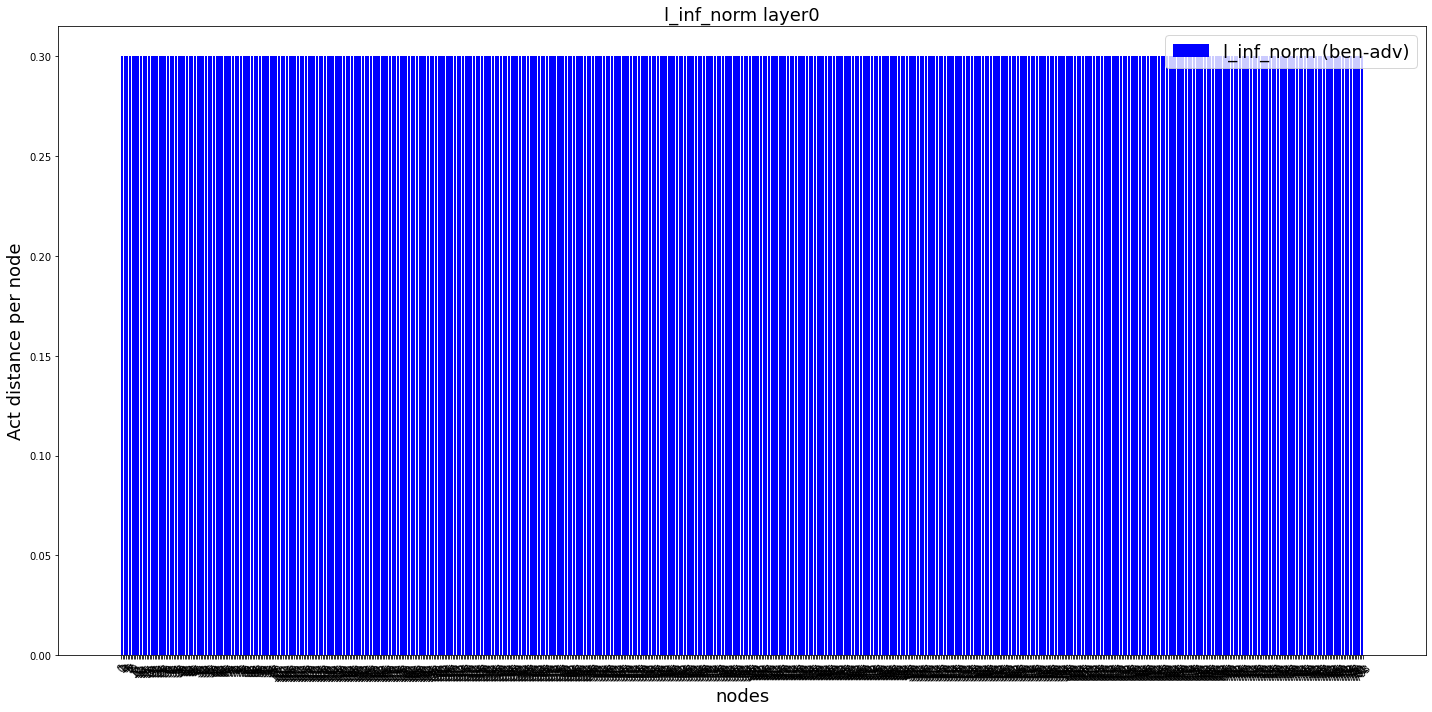

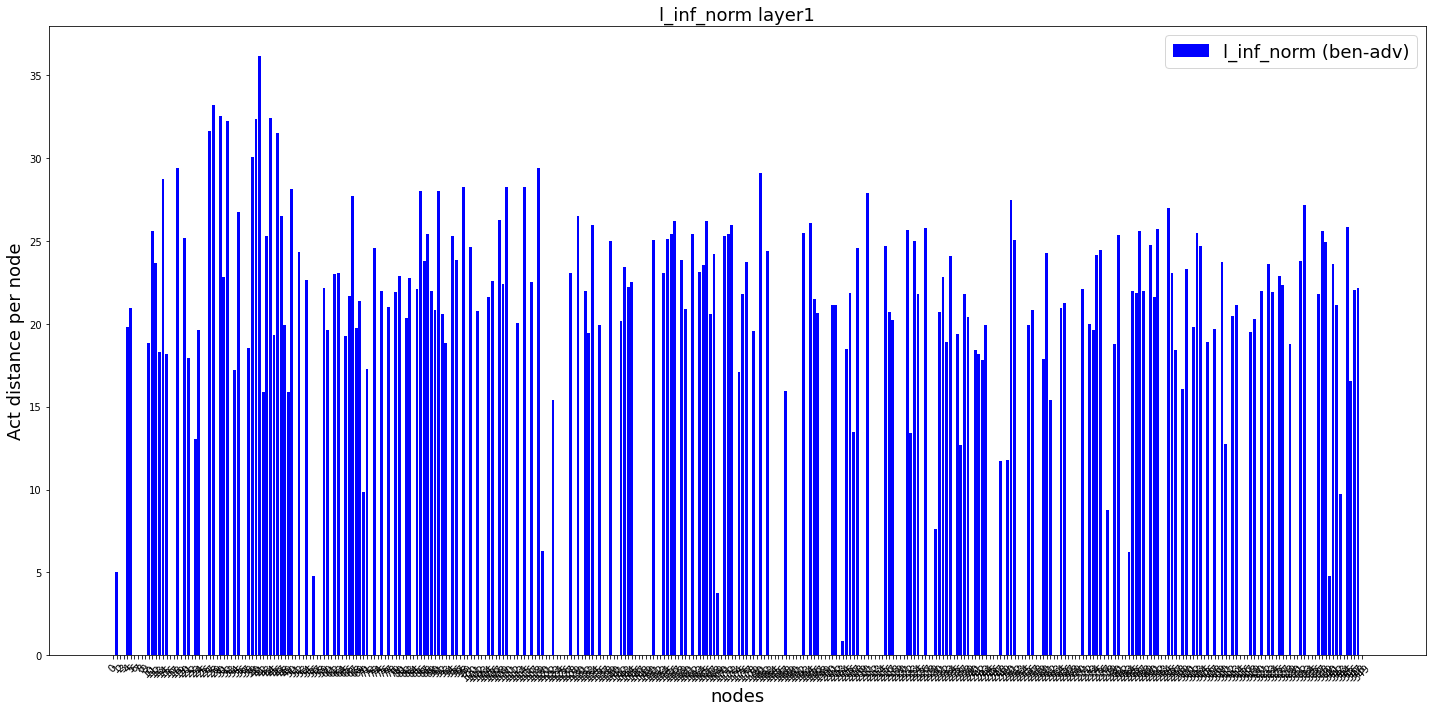

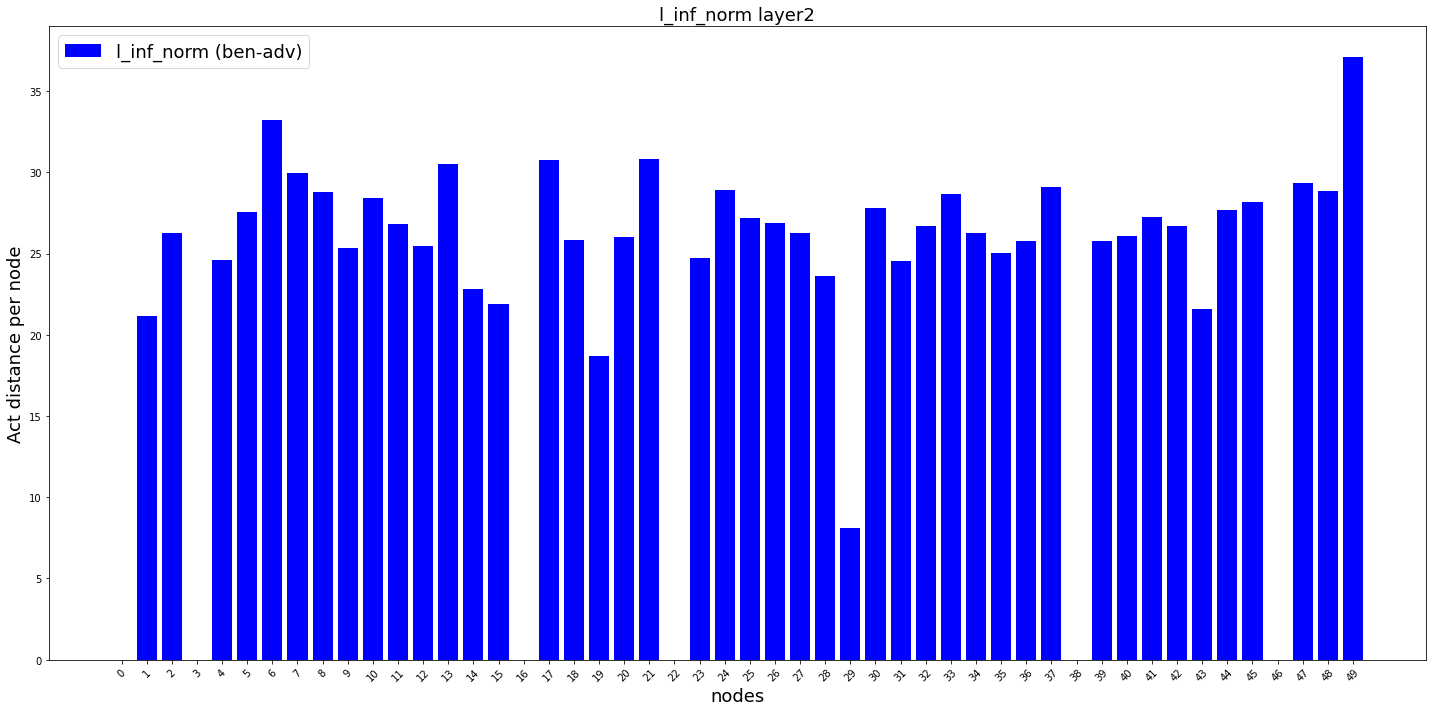

In [6]:
layers_nodes_act={}
index=0
beta={}
for i,layer_dim in enumerate(layer_dims):
    dim=layer_dim[0]
    values_set1 = nodes_act_ben[index:dim+index]
    values_set2 = nodes_act_adv[index:dim+index]
    array1 = np.array(values_set1)
    array2 = np.array(values_set2)
    x=(array1 - array2)
    l_inf_norm = np.linalg.norm(x,axis=1, ord=np.inf)
    layers_nodes_act[layer_dim[1]]=[l_inf_norm]
    plot_act(l_inf_norm,"l_inf_norm",layer_dims.index(layer_dim))
    index+=dim

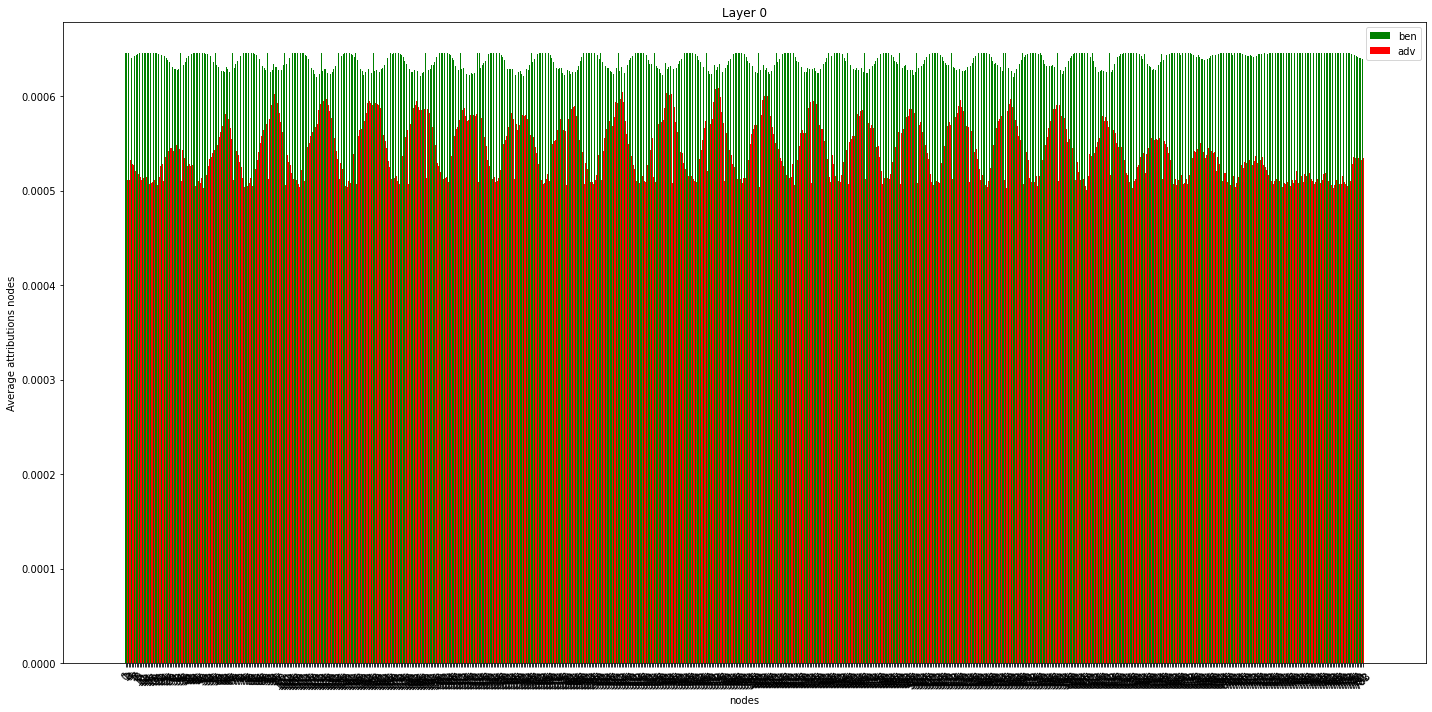

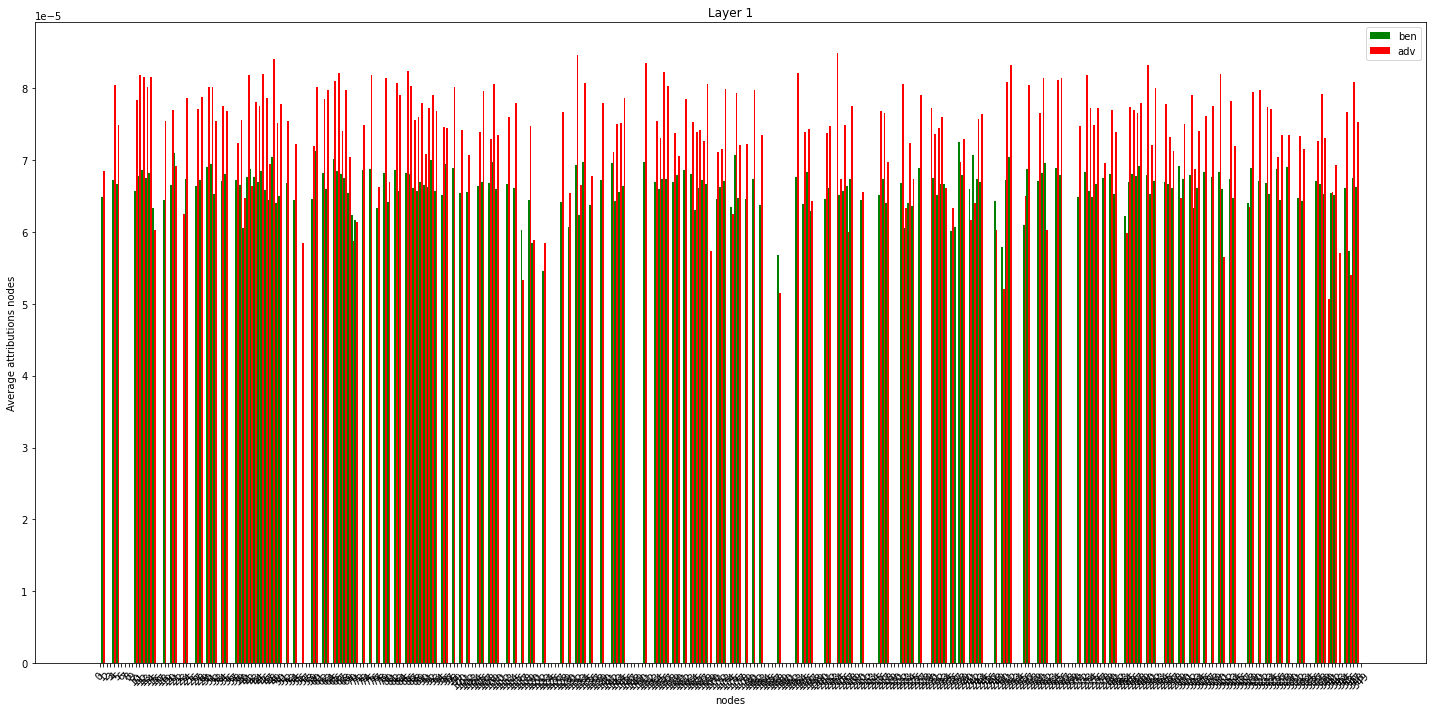

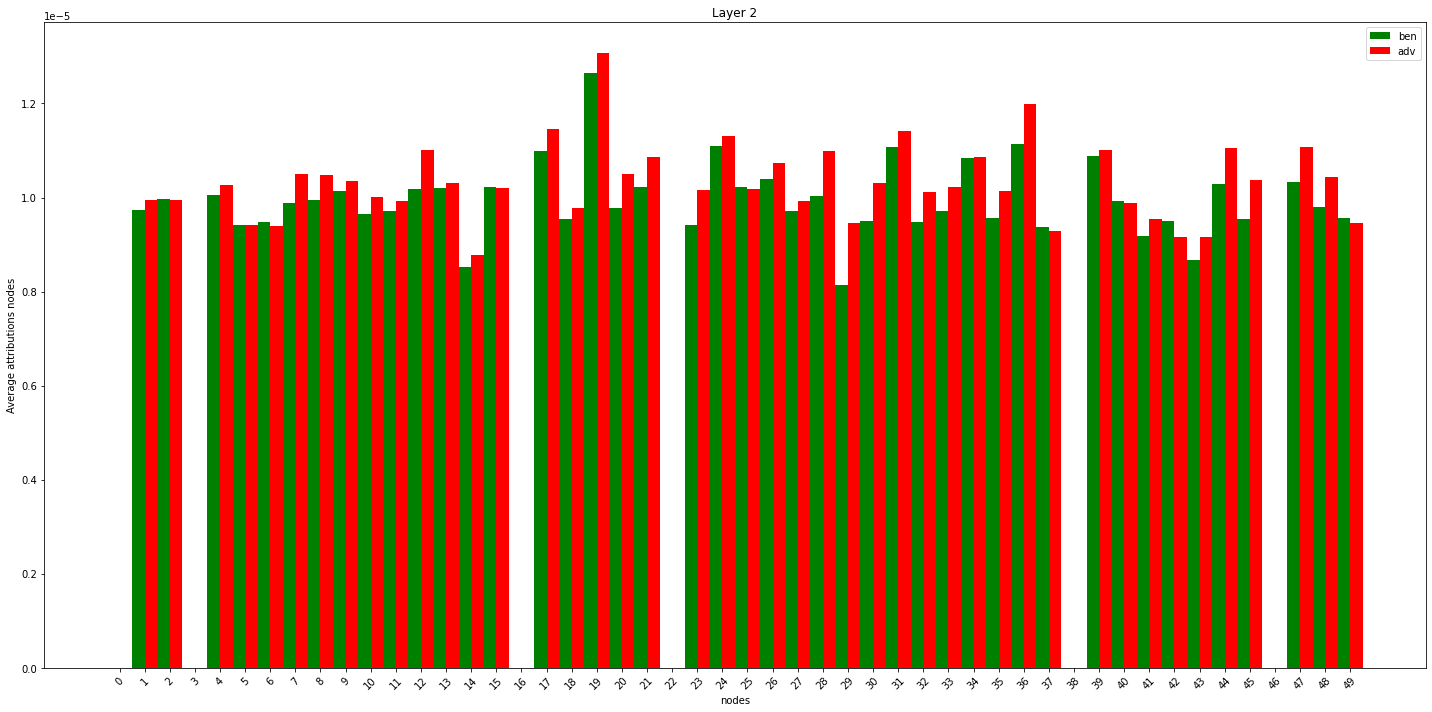

In [7]:
layers_nodes_attri={}
index=0
attri_vals_ben=[]
attri_vals_adv=[]
for layer_dim in layer_dims:
    dim=layer_dim[0]
    values_set1 = [float(torch.Tensor(i)[torch.Tensor(i)!=0].mean().detach().numpy()) if len(torch.Tensor(i)[torch.Tensor(i)!=0])>0 else 0.0  for i in nodes_weights_ben[index:dim+index]]
    values_set2 = [float(torch.Tensor(i)[torch.Tensor(i)!=0].mean().detach().numpy()) if len(torch.Tensor(i)[torch.Tensor(i)!=0])>0 else 0.0  for i in nodes_weights_adv[index:dim+index]]
    attri_vals_ben.append(values_set1)
    attri_vals_adv.append(values_set2)
    plot_attri(values_set1,values_set2,layer_dims.index(layer_dim))
    layers_nodes_attri[layer_dim[1]]=[values_set1,values_set2]
    index+=dim

In [8]:
"""
Fixing all important dictionnaries 
to map the samples edges with the 
whole network edges
"""
dic_all_nodes={}
for i in range (len(all_nodes)):
    dic_all_nodes[all_nodes[i]]=i
dic_all_edges={}
for i in range(len(all_edges)):
    dic_all_edges[all_edges[i][0],all_edges[i][1]]=i
r_dic_all_edges={}
for i in range(len(all_edges)):
    r_dic_all_edges[i]=all_edges[i][0],all_edges[i][1]
edges_attr_adv=[[] for i in range(len(all_edges))]
keyss=dic_all_edges.keys()
samples_attributes=[]


In [10]:
id="_attributes_"+attack
count=0
batch_path=get_checkpoint_name(dataset+"_graph",attack,model_name,folder)
nbr_batch=len(os.listdir(batch_path))
save_path=root_attri+mode+"/"+model_path
count=0
for nbr in range(nbr_batch):
    data_ben=load_graph_data(dataset,model_name,attack=attack,folder=folder,nbr_l_batches=nbr)
    with open(save_path+'/batch_'+str(nbr)+id+'.pickle', 'rb') as handle:
        samples_attributes = pickle.load(handle)
    for j in tqdm(range(len(samples_attributes))):
        hetero_explanation=samples_attributes[j]
        nodes=data_ben[j][2]
        src=hetero_explanation.edge_index[0]
        scores=hetero_explanation.edge_mask
        dst=hetero_explanation.edge_index[1]
        dic_n={}
        for i in nodes:
            dic_n[nodes[i]]=i
        for i in range(len(dst)):
            if (dic_n[int(src[i])],dic_n[int(dst[i])]) in keyss:
                k=dic_all_edges[dic_n[int(src[i])],dic_n[int(dst[i])]]
                #if abs(float(scores[i])*1000)>3 :
                edges_attr_adv[k].append(abs(float(scores[i])*1000))

100%|██████████| 1000/1000 [04:39<00:00,  3.57it/s]


In [11]:
samples_attributes=[]
data_ben=0
edge_atri_matrix=np.ones((len(all_nodes),len(all_nodes)))*0
for i in range(len(edges_attr_adv)):
    if len(edges_attr_adv[i])>0:
        nodes=r_dic_all_edges[i]
        src,dst=dic_all_nodes[nodes[0]],dic_all_nodes[nodes[1]]
        edge_atri_matrix[src][dst]=sum(edges_attr_adv[i])/len(edges_attr_adv[i])*100+10
edge_val=[]
for i in range(len(all_nodes)):
    for j in range(len(all_nodes)):
        if edge_atri_matrix[i][j]>0:
            edge_val.append(edge_atri_matrix[i][j])
edge_val.sort(reverse=True)

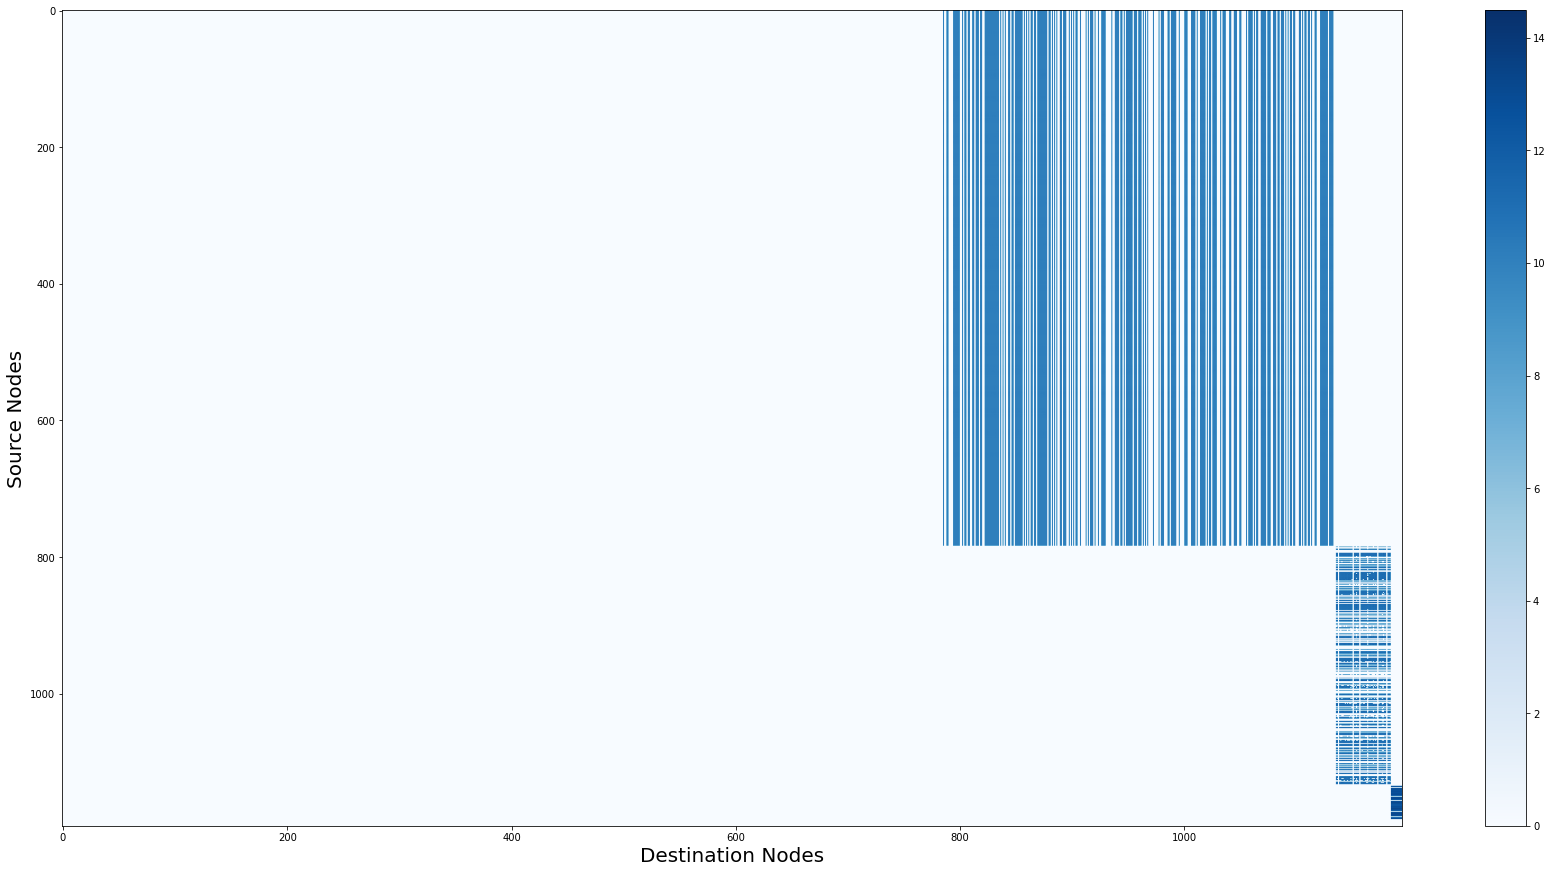

In [12]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(30,15))   # Width x Height in inches
plt.imshow(edge_atri_matrix, cmap='Blues', aspect='auto')
plt.colorbar()
plt.xlabel("Destination Nodes",fontsize=20)
plt.ylabel("Source Nodes",fontsize=20)
#plt.savefig(attack+'_MNIST_Edges.pdf')
plt.show()

In [13]:
edges_attr_ben=[]
edges_attr_ben=[[] for i in range(len(all_edges))]
id="_attributes_ben"
count=0
batch_path=get_checkpoint_name(dataset+"_graph",None,model_name,folder)
nbr_batch=len(os.listdir(batch_path))
save_path=root_attri+mode+"/"+model_path
for nbr in range(nbr_batch):
    data_ben=load_graph_data(dataset,model_name,attack=None,folder=folder,nbr_l_batches=nbr)
    with open(save_path+'/batch_'+str(nbr)+id+'.pickle', 'rb') as handle:
        samples_attributes = pickle.load(handle)
    for j in tqdm(range(len(samples_attributes))):
        hetero_explanation=samples_attributes[j]
        nodes=data_ben[j][2]
        src=hetero_explanation.edge_index[0]
        scores=hetero_explanation.edge_mask
        dst=hetero_explanation.edge_index[1]
        dic_n={}
        stat=len(hetero_explanation.node_mask)==len(nodes)
        if stat:
            for i in nodes:
                dic_n[nodes[i]]=i
            for i in range(len(dst)):
                if (dic_n[int(src[i])],dic_n[int(dst[i])]) in keyss:
                    k=dic_all_edges[dic_n[int(src[i])],dic_n[int(dst[i])]]
                    #if abs(float(scores[i])*1000)>5 :
                    edges_attr_ben[k].append(abs(float(scores[i])*1000))

 33%|███▎      | 329/1000 [01:45<03:28,  3.22it/s]

In [ ]:
edge_atri_matrix=np.ones((len(all_nodes),len(all_nodes)))*0
for i in range(len(edges_attr_adv)):
    if len(edges_attr_ben[i])>0:
        nodes=r_dic_all_edges[i]
        src,dst=dic_all_nodes[nodes[0]],dic_all_nodes[nodes[1]]
        edge_atri_matrix[src][dst]=sum(edges_attr_ben[i])/len(edges_attr_ben[i])+100
edge_val_ben=[]
for i in range(len(all_nodes)):
    for j in range(len(all_nodes)):
        if edge_atri_matrix[i][j]>0:
            edge_val_ben.append(edge_atri_matrix[i][j])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(30,15))   # Width x Height in inches
plt.imshow(edge_atri_matrix, cmap='Blues', aspect='auto')
plt.colorbar()
plt.xlabel("Destination Nodes",fontsize=20)
plt.ylabel("Source Nodes",fontsize=20)
#plt.savefig('Ben_MNIST_Edges.pdf')
plt.show()